In [1]:
# imports
import csv
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os

In [2]:
def containsMarket(column, market=""):
    if market:
        return market in column
    return "am" in column or "sm" in column

def get_longform(df, key):
    frames_col = get_frames_col(df)
    cols = extract_cols(df, key)
    cols.insert(0,frames_col)
    # first create wideform
    df_wideform = df[cols].copy()
    # reshape dataframe into longform
    lf = df_wideform.melt(id_vars=[frames_col], var_name="setting", value_name=key)
    lf.rename(columns={frames_col:'frames'}, inplace=True)
    return lf

def extract_cols(df, key):
    result_cols = []
    for col in df.columns:
        if key in col:
            if not "reward" in col:
                # always safe values
                result_cols.append(col)
            elif "reward_summary" in col:
                result_cols.append(col)
                # if "agent_0" in col:
                #     # always safe agent 0 values
                #     result_cols.append(col)
                # if "mixed" in col or containsMarket(col):
                #     if not "agent_0" in col:
                #         # always add mixed or market values for each agent since they differ from each other
                #         result_cols.append(col)
    return result_cols

def get_frames_col(df):
    for col in df.columns:
        if "frames" in col:
            # since frames don't differ between settings, but i.e. three agents probably 
            # needs more frames pick the column that has the most values
            # (for example check if the value of the last index is not NaN)
            last_value = df[col].iloc[-1]
            if not np.isnan(last_value):
                return col

In [3]:
# read all storage folders to extract training info, i.e. markets and save it to envs
try:
    training_folders = os.listdir('storage') 
except(FileNotFoundError):
    training_folders = []

# while iterating create a wideform dataframe of all csv files
df_settings_dict = {}

for folder in training_folders:
    if "plot_results" in folder or "dqn_comparisons" in folder:
        continue

    # read csv file (if it exists)
    try:
        df_settings_dict[folder] = pd.read_csv('storage/'+folder+'/log.csv')
    except:
        continue

    # add setting to the df columns
    df_settings_dict[folder].columns = [folder + "_" + str(col) for col in df_settings_dict[folder].columns]
    
# join all dataframes (one per setting)
all_data_df = pd.concat([df for df in df_settings_dict.values()], axis=1)

In [4]:
keys = ["reward_summary", "mean_grid_coloration_percentage", "mean_num_reset_fields", "fully_colored", "mean_num_frames_per_episode", "mean_trades"]
base_settings = ["dqn", "ppo", "mixed", "mixed-competitive", "percentage", "rooms","rooms-mixed","rooms-percentage","rooms-mixed-competitive"]


# generate normalized rewards and longforms
lf_settings_dicts = {}
lf_comparison_settings_dict = {}
df = pd.concat([df for setting, df in df_settings_dict.items() if "rooms" not in setting], axis=1)

# settings = []
# min_value = None
# max_value = None

# for col in df.columns:
#     if "mean_reward" in col:
#         if min_value is None or min_value >= df[col].min():
#             min_value = df[col].min()
#         if max_value is None or max_value <= df[col].max():
#             max_value = df[col].max()
#         if "agent_0" in col:
#             settings.append(col.split("_mean_reward")[0])
# print("min: " + str(min_value))
# print("max: " + str(max_value))
# print(settings)
for setting in df_settings_dict.keys():
    if "rooms" in setting:
        continue
    settings_df = df_settings_dict[setting].copy()
    reward_cols = [col for col in settings_df.columns if setting+"_mean_reward" in col]
    new_col = setting+"_reward_summary"
    settings_df[new_col] = settings_df[reward_cols].sum(axis='columns')
    # normalize values here
    col_min = settings_df[new_col].min()
    col_max = settings_df[new_col].max()
    settings_df[new_col] = (settings_df[new_col]-col_min)/(col_max-col_min)
    for key in keys:
        # create longforms
        index = setting+ "_" + key
        lf_settings_dicts[index] = get_longform(settings_df, key)

        if containsMarket(setting):
            #to be compared with base setting!
            base_setting = setting.split("-am")[0] if "-am" in setting else setting.split("-sm")[0]
            base_market = base_setting + "-am" if "-am" in setting else base_setting + "-sm"
            market_index = base_market + "_" + key
            if market_index not in lf_comparison_settings_dict:
                if "reward" in key:
                    # in that case calculate and add the base data first to compare it with later on!
                    base_df = df_settings_dict[base_setting].copy()
                    reward_cols = [col for col in base_df.columns if base_setting+"_mean_reward" in col]
                    new_col = base_setting+"_reward_summary"
                    base_df[new_col] = base_df[reward_cols].sum(axis='columns')
                    
                    base_col_min = base_df[new_col].min()
                    base_col_max = base_df[new_col].max()
                    # normalize values here
                    base_df[new_col] = (base_df[new_col]-base_col_min)/(base_col_max-base_col_min)
                else: 
                    base_df = df_settings_dict[base_setting]
                lf_base = get_longform(base_df, key)
                lf_comparison_settings_dict[market_index] = lf_base
            lf_comparison_settings_dict[market_index] = lf_comparison_settings_dict[market_index].append(lf_settings_dicts[index], ignore_index=True)
        
        if "1-dqn" in setting or "1-ppo" in setting or "3-ppo-dr" in setting:
            # those settings do not (/ should not) have markets
            lf_comparison_settings_dict[index] = lf_settings_dicts[index]

print([k for k in lf_comparison_settings_dict.keys() if "summary" in k])

['1-dqn-15_reward_summary', '1-ppo_reward_summary', '1-ppo-sm_reward_summary', '1-ppo-small_reward_summary', '2-ppo-sm_reward_summary']


In [5]:
durations = []
for col in all_data_df.columns:
    if ("-ppo" in col or "-dqn" in col) and "duration_in_seconds" in col:
        index = all_data_df[col].last_valid_index()
        duration = all_data_df.at[index,col]
        if duration >= 6000: # higher than 1 1/2 hours
            print(col + " with duration " + str(duration) + " in hours: " + str((duration/60)/60))
        durations.append(all_data_df.at[index,col])

print("overall duration in hours " + str((sum(durations)/60)/60)) #prints duration of all settings in hours

1-dqn-15_duration_in_seconds with duration 17999.0 in hours: 4.999722222222222
overall duration in hours 5.735555555555555


Specs:
2_fully_colored:  batch 64  | target update 100.000 | replay size 700.000 | epsilon decay 400.000
9_fully_colored:  batch 64  | target update 100.000 | replay size 800.000 | epsilon decay 400.000
13_fully_colored: batch 64  | target update 100.000 | replay size 100.000 | epsilon decay 400.000
15_fully_colored: batch 64  | target update 100.000 | replay size 800.000 | epsilon decay 400.000 (changed initial target update from 1000 to 500)


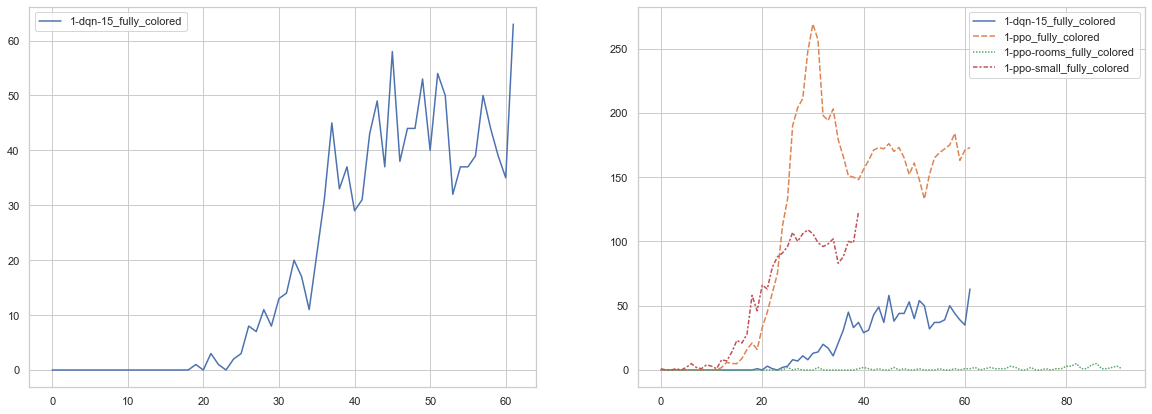

In [6]:
sns.set_theme(style="whitegrid")

dqn_fully_colored = [col for col in all_data_df.columns if "fully_colored" in col and "1-dqn" in col and (col.split("1-dqn-")[1][0] == "2" or  col.split("1-dqn-")[1][0] == "9" or "13" in col.split("1-dqn-")[1] or "15" in col.split("1-dqn-")[1] )]

all_fully_colored = [col for col in all_data_df.columns if "fully_colored" in col]
all_durations = [col for col in all_data_df.columns if "duration" in col and "1-dqn" in col and ( col.split("1-dqn-")[1][0] == "2" or  col.split("1-dqn-")[1][0] == "9" or "13" in col.split("1-dqn-")[1] or "15" in col.split("1-dqn-")[1] )]

ppo_comparison = [col for col in all_data_df.columns if "fully_colored" in col and ( "1-ppo" in col or "dqn" in col)]
# print([col for col in df.columns if "frames" in col])
fig, axs = plt.subplots(ncols=2, figsize=(20, 7))
sns.lineplot(data=all_data_df[dqn_fully_colored], ax=axs[0])
# sns.lineplot(data=df[all_fully_colored], ax=axs[1])
# sns.lineplot(data=df[all_durations], ax=axs[1])
# sns.barplot(data=df[all_durations], ax=axs[1])
sns.lineplot(data=all_data_df[ppo_comparison], ax=axs[1])

print("Specs:")
print("2_fully_colored:  batch 64  | target update 100.000 | replay size 700.000 | epsilon decay 400.000")
print("9_fully_colored:  batch 64  | target update 100.000 | replay size 800.000 | epsilon decay 400.000")
print("13_fully_colored: batch 64  | target update 100.000 | replay size 100.000 | epsilon decay 400.000")
print("15_fully_colored: batch 64  | target update 100.000 | replay size 800.000 | epsilon decay 400.000 (changed initial target update from 1000 to 500)")

# print("1_fully_colored:  batch 64  | target update 10.000  | replay size 700.000 | epsilon decay 400.000")
# print("2_fully_colored:  batch 64  | target update 100.000 | replay size 700.000 | epsilon decay 400.000")
# print("3_fully_colored:  batch 128 | target update 70.000  | replay size 700.000 | epsilon decay 350.000")
# print("4_fully_colored:  batch 64  | target update 50.000  | replay size 700.000 | epsilon decay 350.000")
# print("6_fully_colored:  batch 64  | target update 150.000 | replay size 500.000 | epsilon decay 300.000")
# print("5_fully_colored:  batch 64  | target update 100.000 | replay size 500.000 | epsilon decay 300.000")
# print("7_fully_colored:  batch 64  | target update 200.000 | replay size 700.000 | epsilon decay 300.000")
# print("8_fully_colored:  batch 64  | target update 100.000 | replay size 700.000 | epsilon decay 300.000")
# print("9_fully_colored:  batch 64  | target update 100.000 | replay size 800.000 | epsilon decay 400.000")
# print("10_fully_colored: batch 128 | target update 100.000 | replay size 700.000 | epsilon decay 400.000")
# print("11_fully_colored: batch 64  | target update 400.000 | replay size 700.000 | epsilon decay 400.000")
# print("12_fully_colored: batch 32  | target update 50.000  | replay size 700.000 | epsilon decay 400.000")
# print("13_fully_colored: batch 64  | target update 100.000 | replay size 100.000 | epsilon decay 400.000")
# print("15_fully_colored: batch 64  | target update 100.000 | replay size 800.000 | epsilon decay 400.000 (changed initial target update from 1000 to 500)")

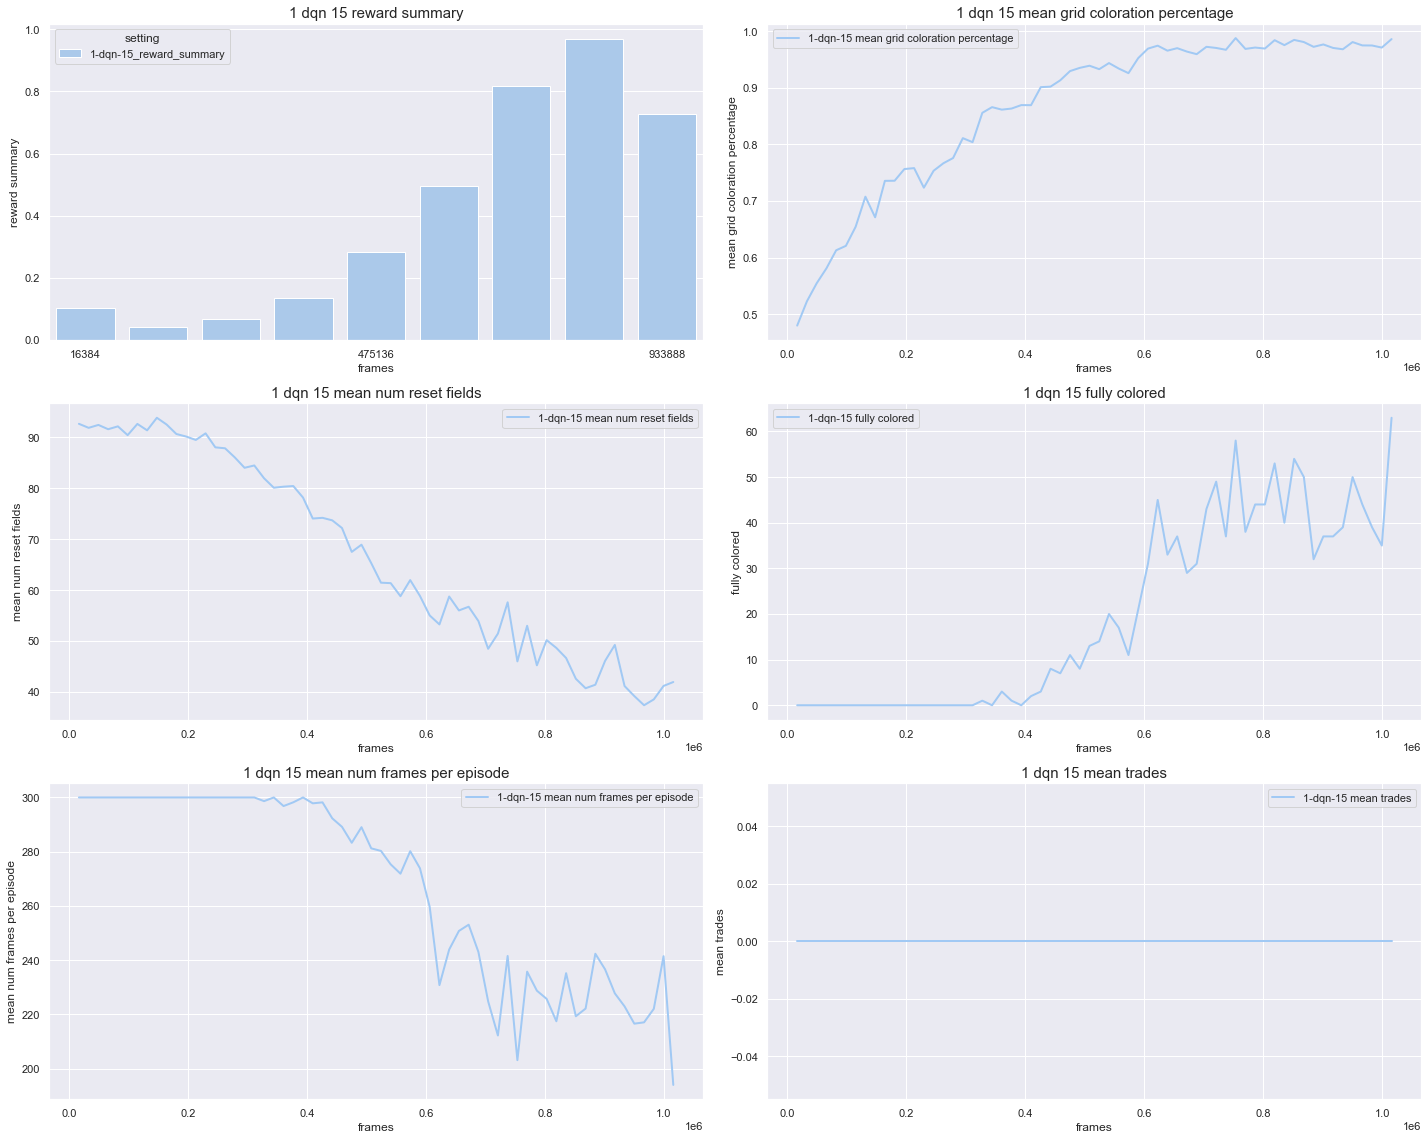

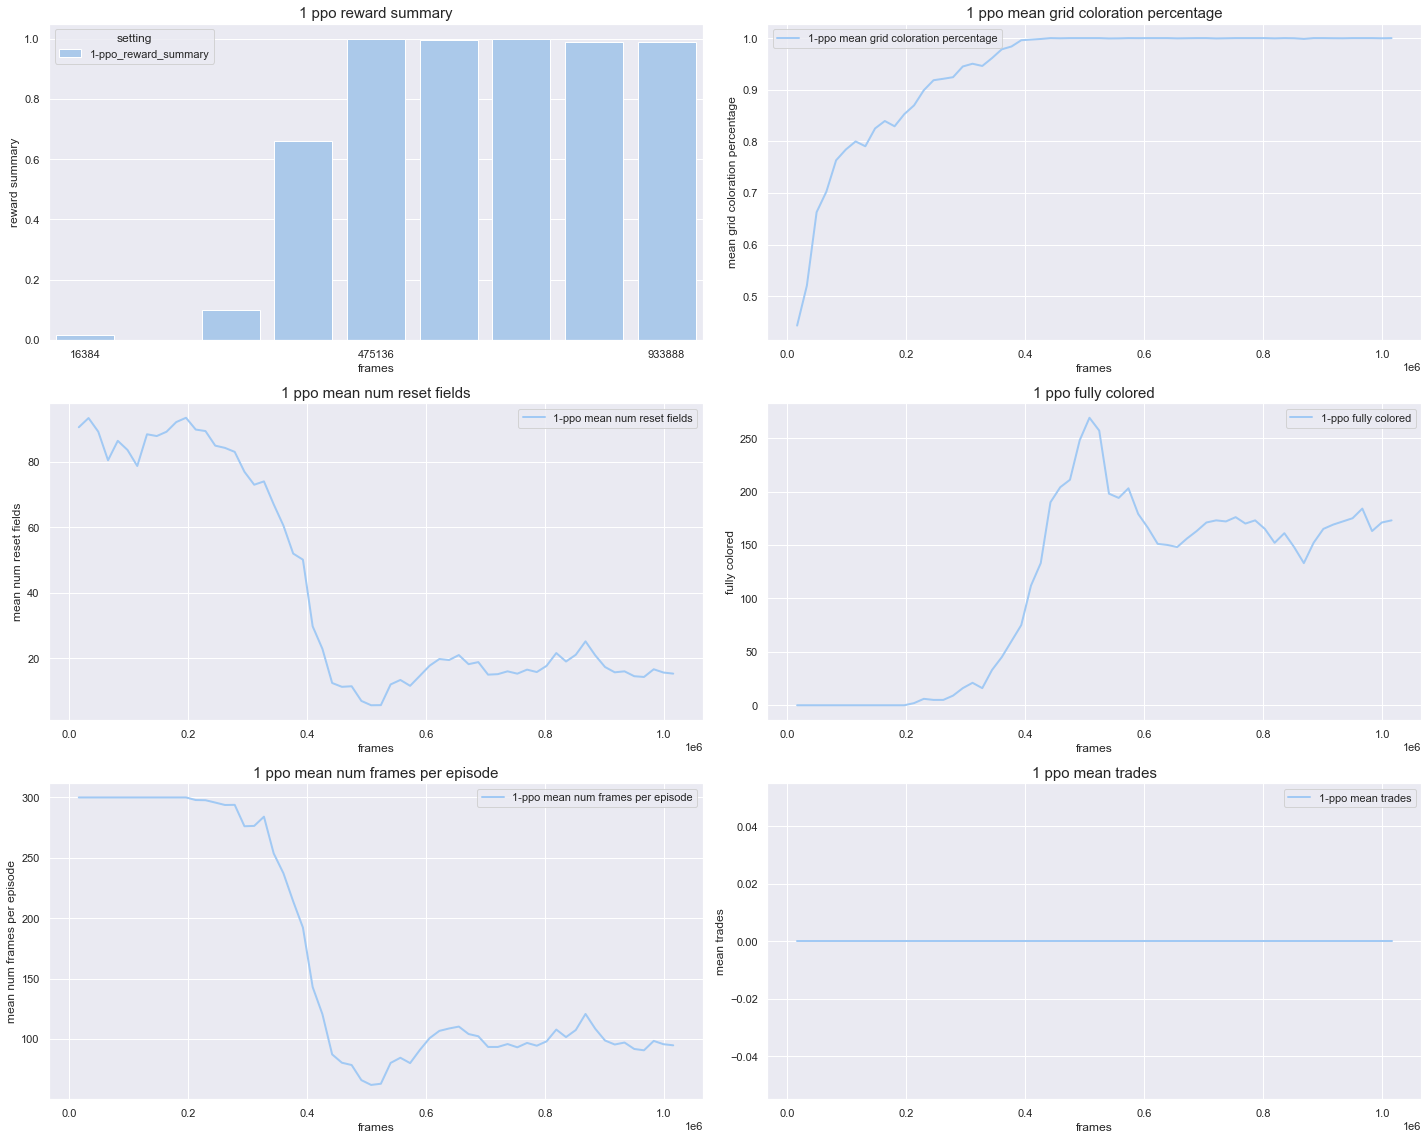

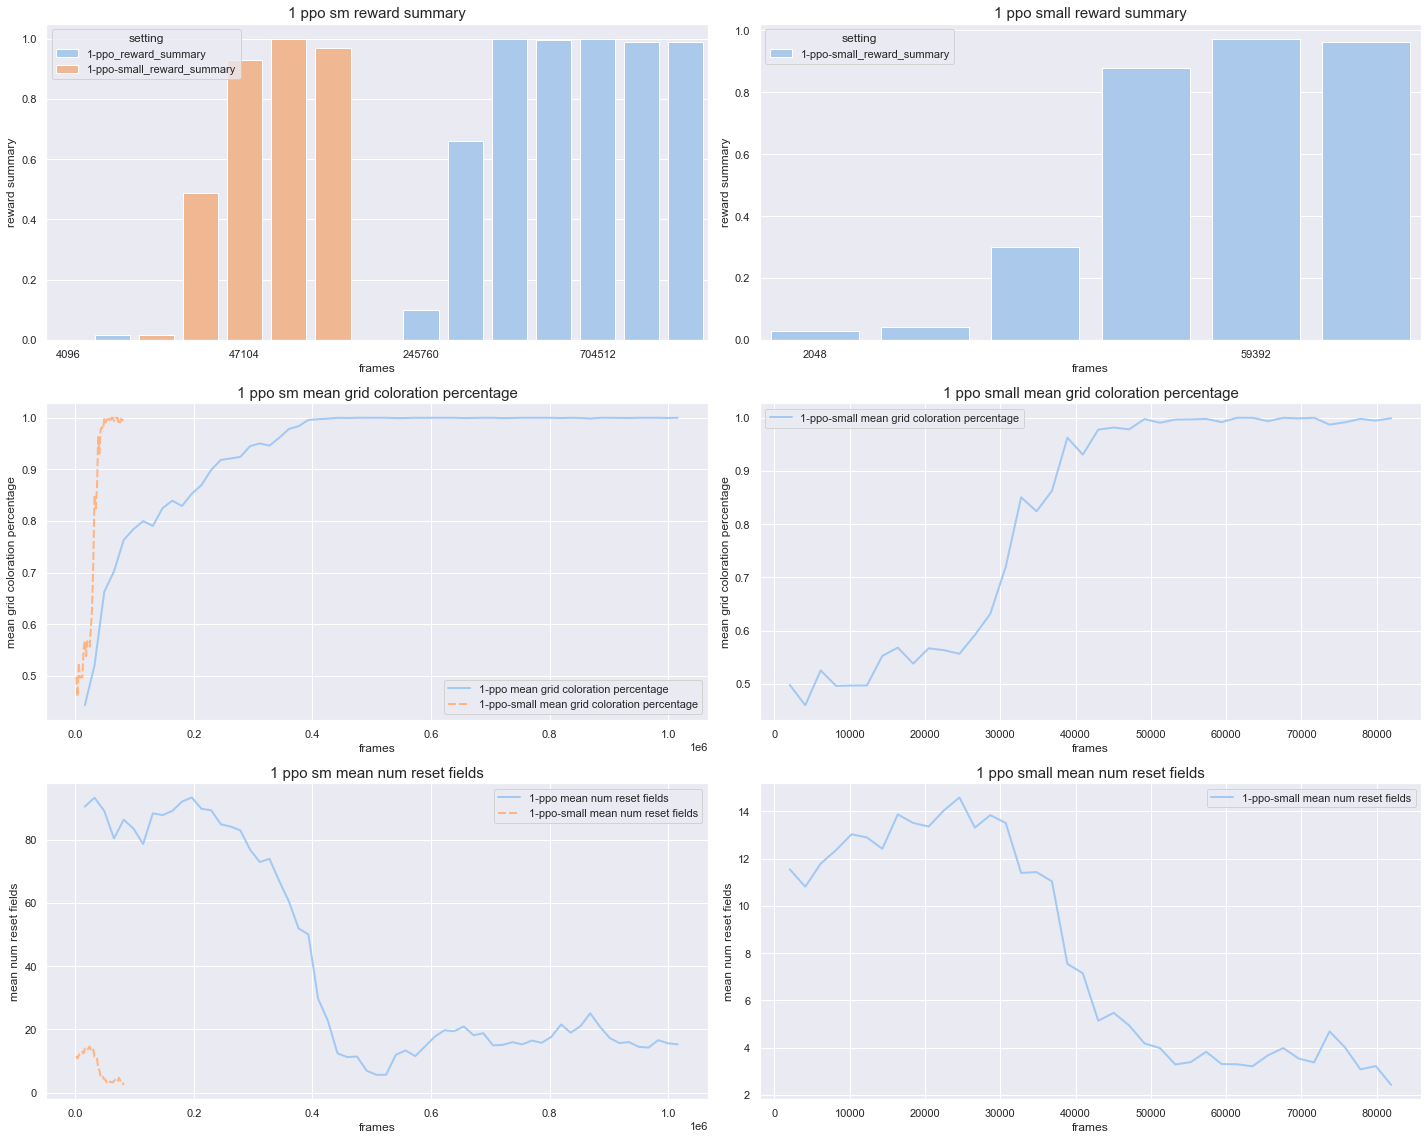

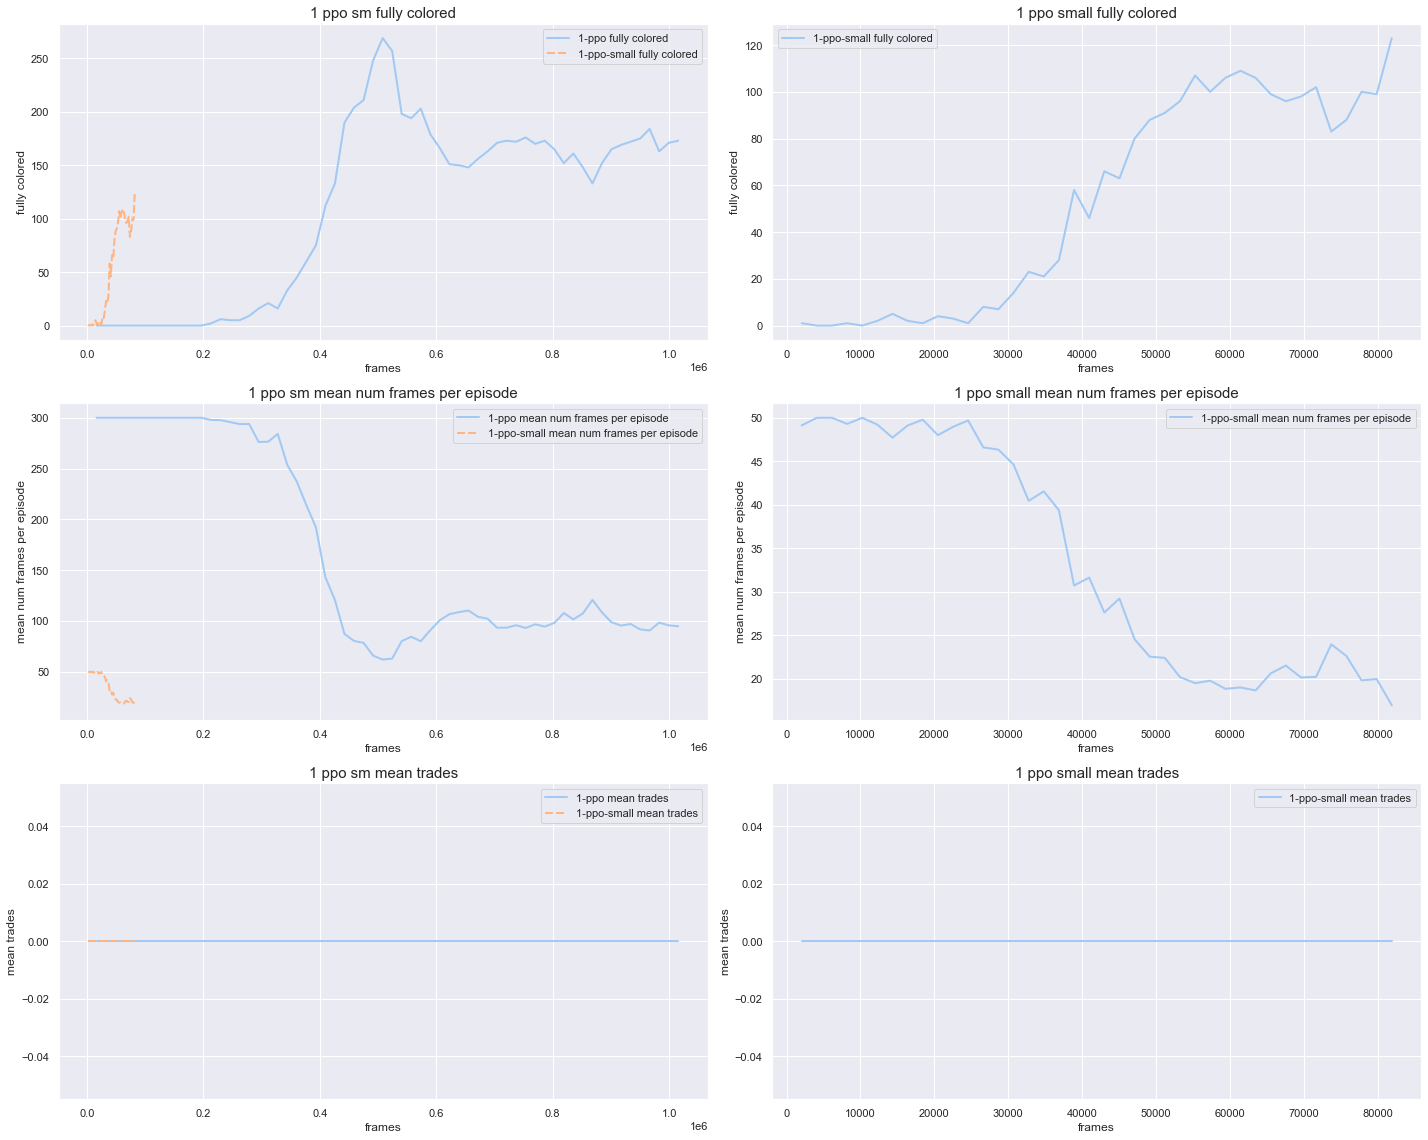

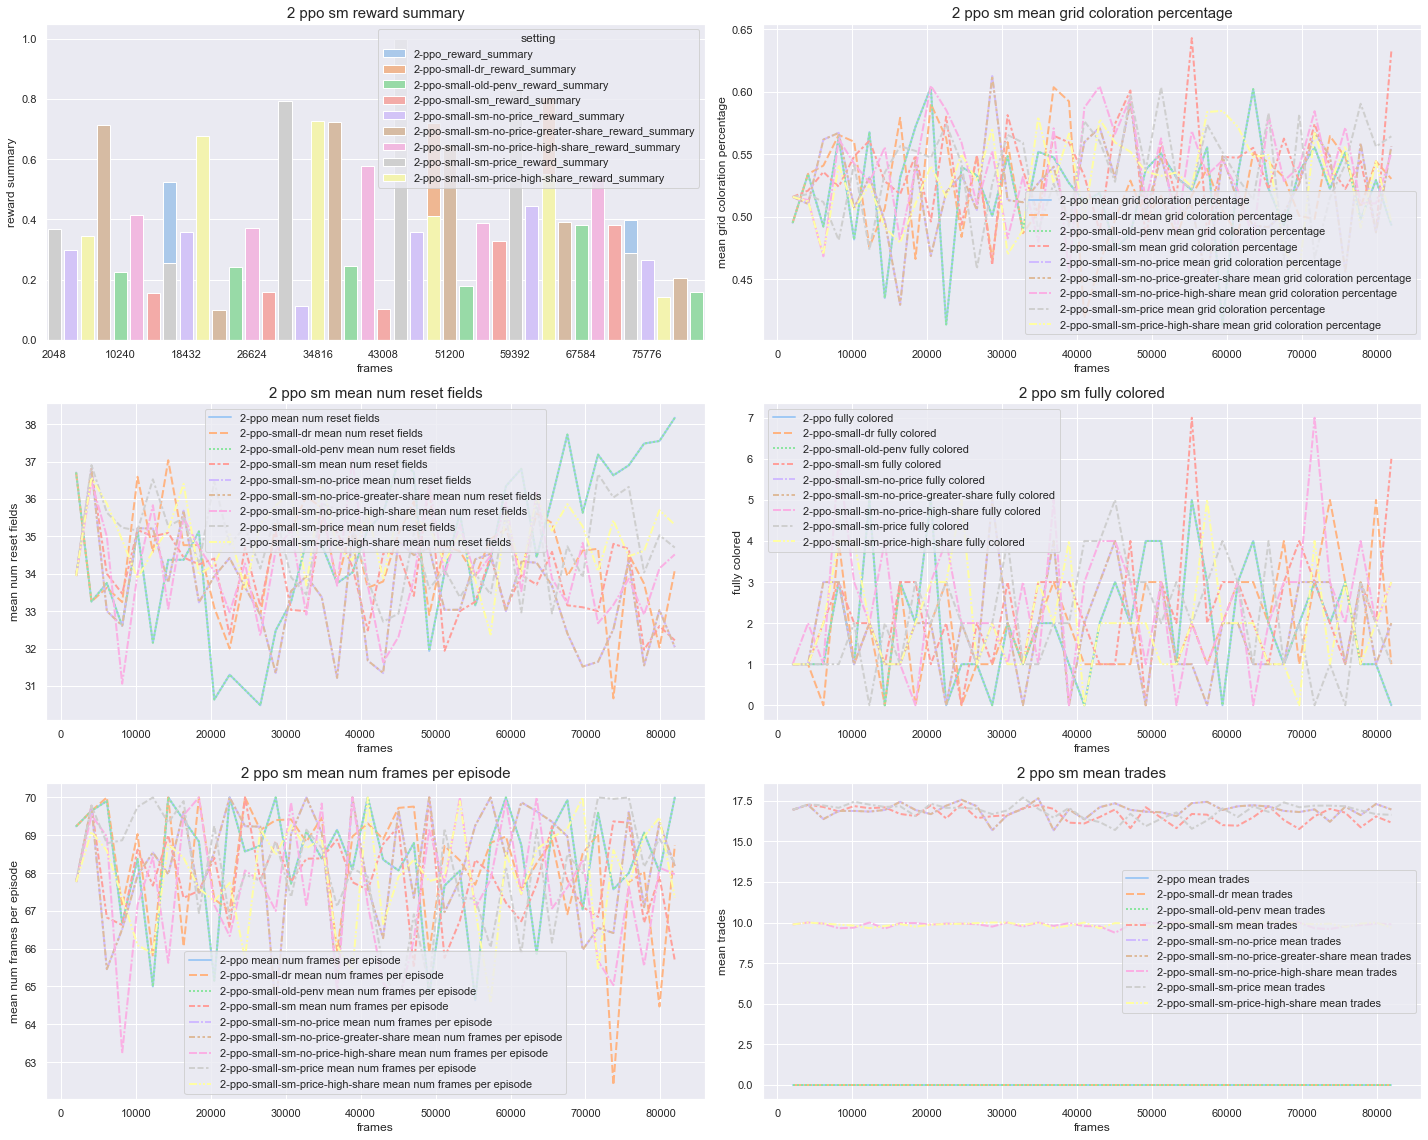

In [7]:
settings = [s for s in df_settings_dict.keys() if (containsMarket(s) or "1-ppo" in s or "1-dqn" in s or "1-ppo-dr" in s) and not "room" in s]

sns.set_theme()
max_col = 2
max_row = 3
col = 0
row = 0
for setting in lf_comparison_settings_dict.keys():
    if row >= max_row or (row == 0 and col == 0): 
        row = 0
        # create new plot
        f, axes = plt.subplots(nrows=max_row, ncols=max_col, figsize=(20, 16)) #, sharex=True
        plt.subplots_adjust(hspace=0.3)
    title = " ".join(setting.replace("_", "-").split("-"))
    # for key in keys:
        # if setting+"_"+key not in lf_comparison_settings_dict.keys():
        #     continue
    key = [k for k in keys if k in setting][0]
    y_label = " ".join(key.split("_"))
    if "reward" in key:
        g = sns.barplot(
            data=lf_comparison_settings_dict[setting].iloc[::7, :], 
            x="frames", y=key, hue="setting", palette="pastel", ax=axes[row, col], dodge=False
        )
        # g.set_xticklabels(g.get_xticklabels(), rotation=40, ha="right")
        n = 4  # Keeps every 7th label
        [l.set_visible(False) for (i,l) in enumerate(g.xaxis.get_ticklabels()) if i % n != 0]
    else:
        g = sns.lineplot(data=lf_comparison_settings_dict[setting], legend="brief", x="frames", y=key, hue="setting", style="setting", ax=axes[row, col], linewidth=2, palette="pastel") #"magma" | "viridis"
        # g.set(ylabel=y_label, title=title)

        #beatify plot legend labels
        _, labels = g.get_legend_handles_labels()
        for index, label in enumerate(labels):
            new_label = " ".join(label.split("_")).replace(title+" ", "")
            labels[index] = new_label
        g.legend(labels=labels)
    axes[row, col].set_ylabel(y_label)
    axes[row, col].set_title(title, fontsize = 15.0)

    col += 1
    if col == max_col:
        row += 1
        col = 0

    f.tight_layout()

KeyError: '1-ppo-rooms_reward_summary'

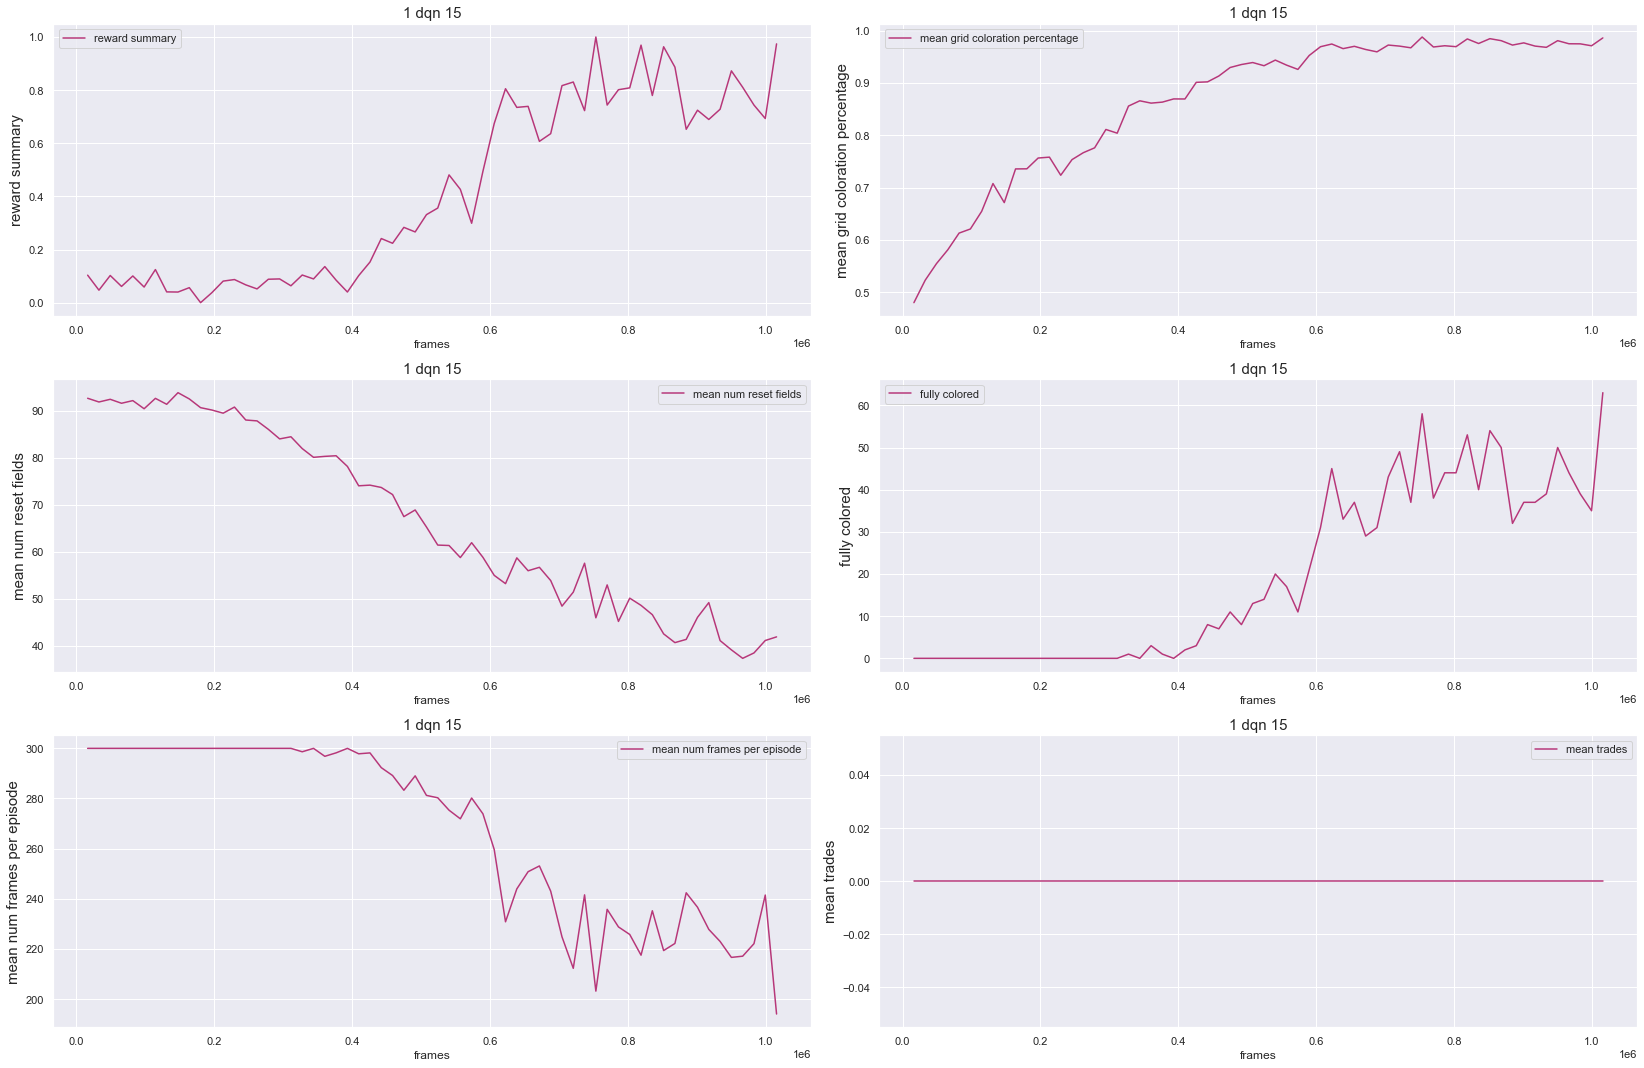

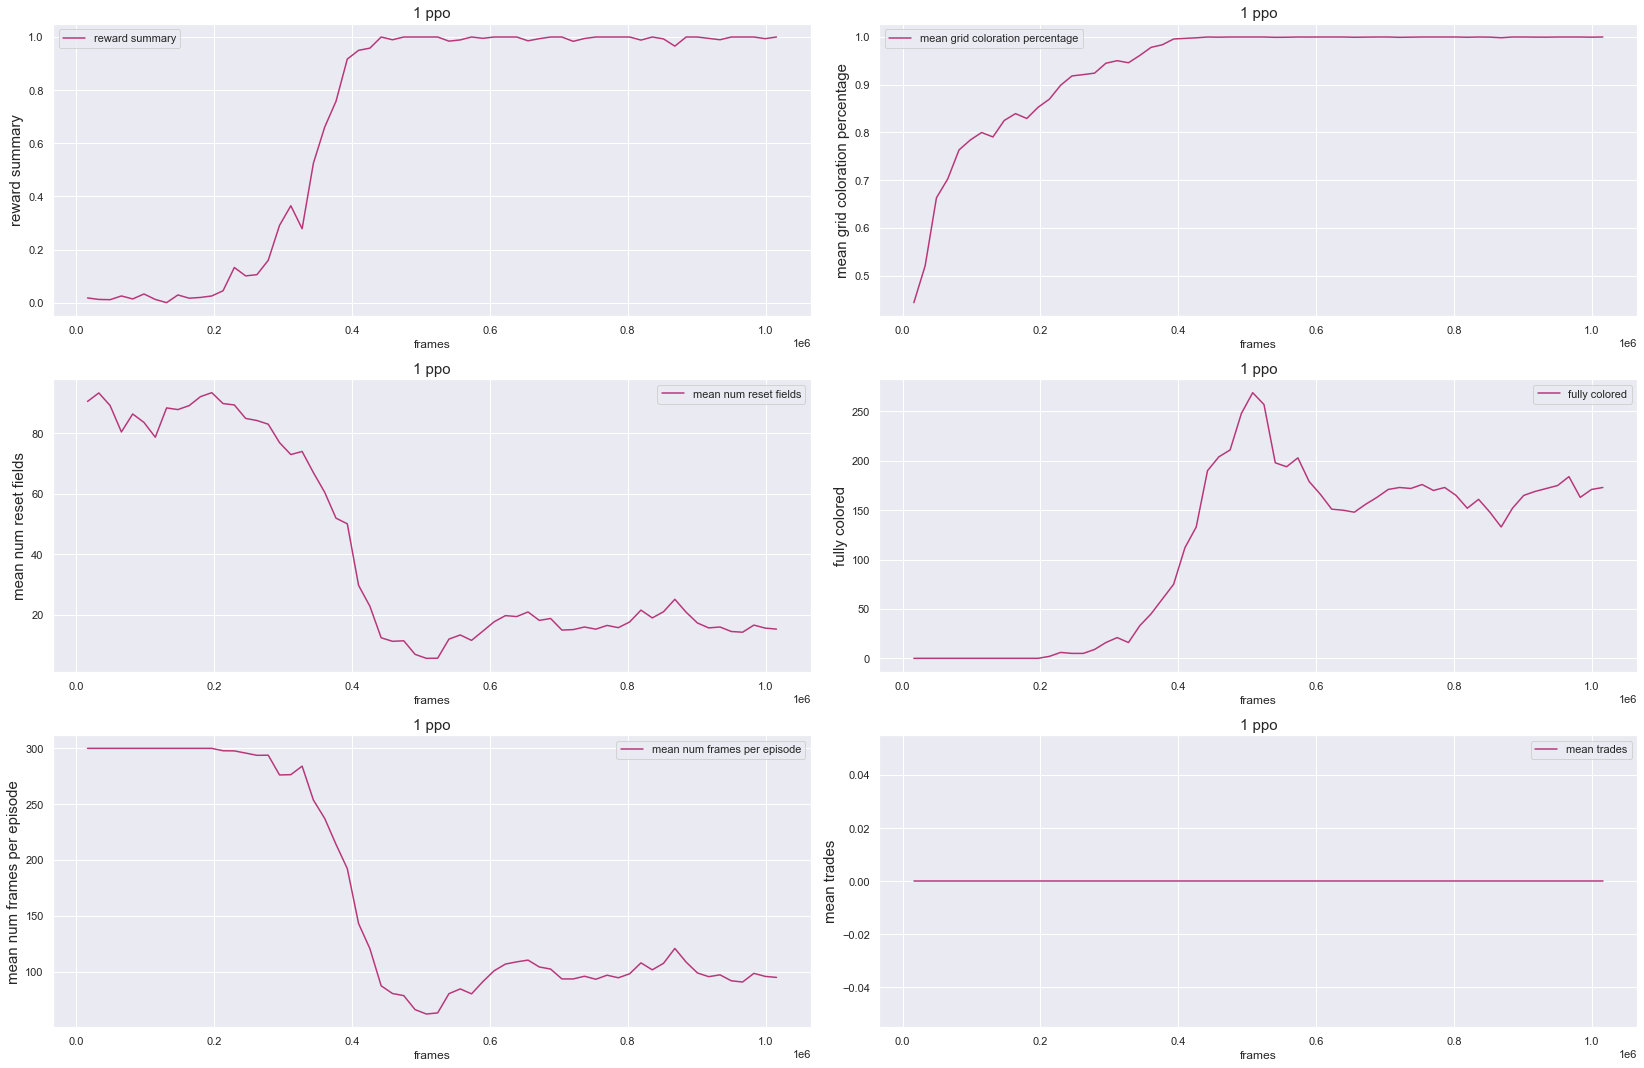

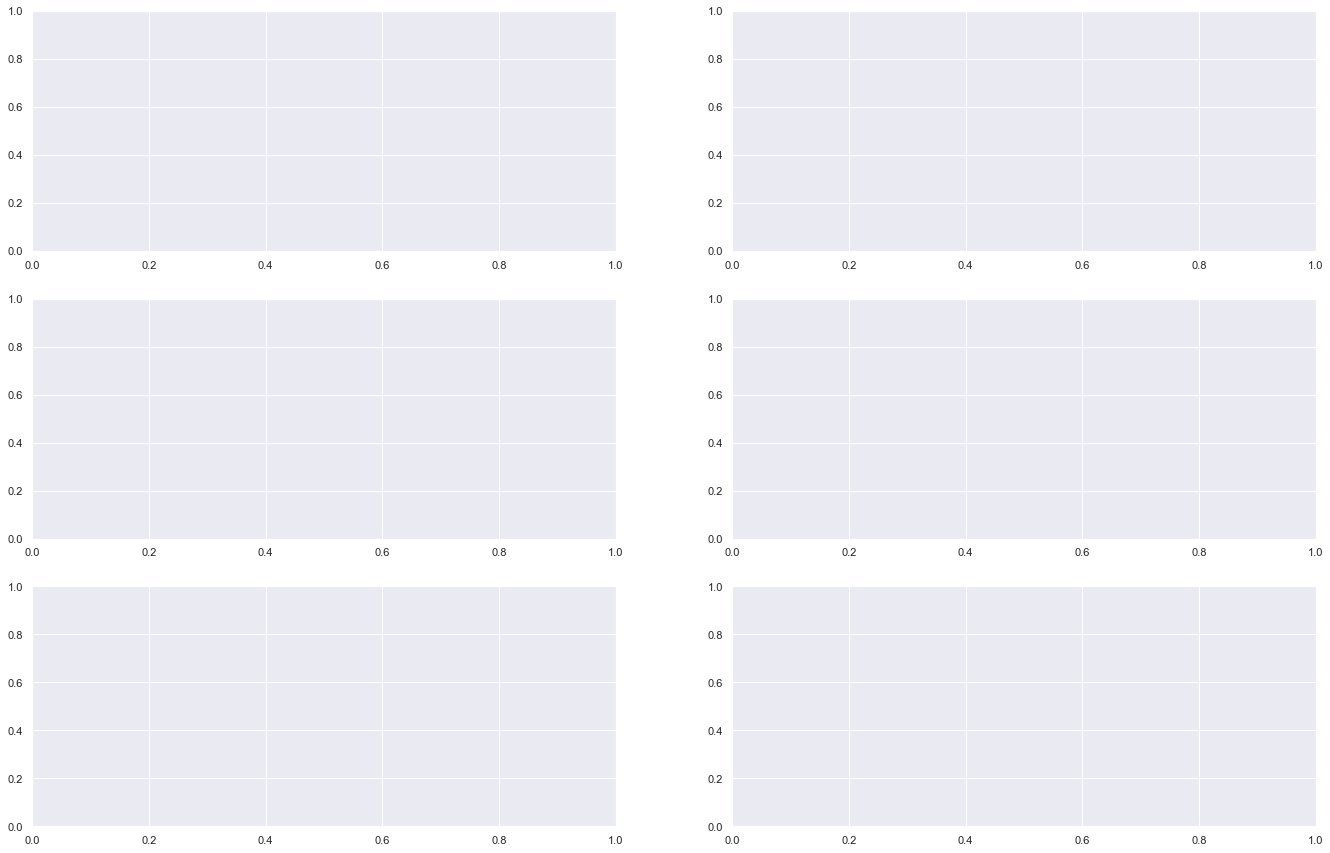

In [8]:
for setting in df_settings_dict.keys():
    #define how many subplots
    sns.set_theme()
    max_col = 2
    f, axes = plt.subplots(nrows=3, ncols=max_col, figsize=(23, 15)) #, sharex=True
    col = 0
    row = 0
    title = " ".join(setting.split("-"))
    for key in keys:
        y_label = " ".join(key.split("_"))
        g = sns.lineplot(data=lf_settings_dicts[setting+"_"+key], x="frames", y=key, hue="setting", ax=axes[row, col], palette="magma")
        axes[row, col].set_ylabel(y_label, fontsize = 15.0)
        axes[row, col].set_title(title, fontsize = 15.0)
        # g.set(ylabel=y_label, title=title)

        #beatify plot legend labels
        _, labels = g.get_legend_handles_labels()
        for index, label in enumerate(labels):
            new_label = " ".join(label.split(setting+"_")[1].split("_"))
            labels[index] = new_label
        g.legend(labels=labels)

        col += 1
        if col == max_col:
            row += 1
            col = 0

    # plt.setp(axes)
    # plt.title(title)
    plt.tight_layout()

In [ ]:
def multiplot(columns_list, key):
    sns.set_theme(style="dark")

    # print(market_settings)
    for columns in columns_list:
        if not any("frames" in setting_col for setting_col in columns):
            # print(setting)
            columns.append(get_frames_col(all_data_df))

        df_complete = all_data_df[columns].copy()
        lf_complete = get_longform(df_complete, key)

        if any("agent_0" in column for column in columns):
            agent_zero_cols = [col for col in columns if "agent_0" in col or "frames" in col]
            # other_agents_cols = [col for col in columns if not "agent_0" in col or "frames" in col]
            df_filtered = all_data_df[agent_zero_cols].copy()
            lf_filtered = get_longform(df_filtered, key)
            
            # Plot each year's time series in its own facet
            g = sns.relplot(
                data=lf_filtered,
                x="frames", y=key, col="setting", hue="setting",
                kind="line", palette="crest", linewidth=2, zorder=5,
                col_wrap=2, height=5, aspect=3, legend=False
            )
        else:
            # Plot each year's time series in its own facet
            g = sns.relplot(
                data=lf_complete,
                x="frames", y=key, col="setting", hue="setting",
                kind="line", palette="crest", linewidth=4, zorder=5,
                col_wrap=2, height=5, aspect=3, legend=False
            )


        # Iterate over each subplot to customize further
        for s, ax in g.axes_dict.items():
            title = " ".join(s.split("_mean")[0].split("-"))
            # s=current plot!! Add the title as an annotation within the plot
            ax.text(.7, .85, title, transform=ax.transAxes, fontweight="bold")
            if "agent_0" in s: # check if more agent infos are available and plot them too!
                # in this case the agents have different values -> show all 
                # Plot every line greyed in the background
                setting = s.split("_agent")[0]
                lf_contains_agent = lf_complete[lf_complete['setting'].str.contains(setting)]
                lf_does_not_contain_agent = lf_complete[~lf_complete['setting'].str.contains(setting)]
                sns.lineplot(
                    data=lf_contains_agent, x="frames", y=key, zorder=5,
                    linewidth=2, ax=ax, hue="setting"
                )
                # Plot every line greyed in the background
                sns.lineplot(
                    data=lf_does_not_contain_agent, x="frames", y=key, units="setting",
                    estimator=None, color=".7", linewidth=1, ax=ax
                )
            else:
                sns.lineplot(
                    data=lf_complete, x="frames", y=key, units="setting",
                    estimator=None, color=".7", linewidth=1, ax=ax
                )

        # Reduce the frequency of the x axis ticks
        ax.set_xticks(ax.get_xticks()[::2])

        # Tweak the supporting aspects of the plot
        g.set_titles("")
        g.set_axis_labels("", key)
        # g.tight_layout()